In [292]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import matplotlib.patches as mpatches
import ast
from itertools import combinations
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 


pd.set_option('display.max_columns', None)

### Compile all the hero information

In [57]:
hero_detail_path = './heroes/heroes/heroes'

pro_con_path = os.path.join(hero_detail_path, 'hero_pro_con.json')
bio_path = os.path.join(hero_detail_path, 'heroes_bios.json')
counter_path = os.path.join(hero_detail_path, 'heroes_counter.json')
url_path = os.path.join(hero_detail_path, 'heroes_url.json')

In [58]:
basic_hero_df = pd.read_csv('dota2_heroes.csv')
hero_pro_con_df = pd.read_json(pro_con_path)
hero_bio_df = pd.read_json(bio_path)
hero_counter_df = pd.read_json(counter_path)
hero_url_df = pd.read_json(url_path)

In [59]:
# replace nature's prophet
hero_pro_con_df.replace('Nature%27s_Prophet', "Nature's_Prophet", inplace=True)
hero_bio_df.replace('Nature%27s_Prophet', "Nature's_Prophet", inplace=True)
hero_counter_df.replace('Nature%27s_Prophet', "Nature's_Prophet", inplace=True)
hero_url_df.replace('Nature%27s_Prophet', "Nature's_Prophet", inplace=True)

basic_hero_df.drop(columns=['ingame_name','en_name'], inplace=True)
basic_hero_df['name_id'] = basic_hero_df['official_name'].apply(lambda x:x.lower().replace('-','').replace('_','').replace(' ',''))
hero_pro_con_df['name_id'] = hero_pro_con_df['hero'].apply(lambda x:x.lower().replace('-','').replace('_','').replace(' ',''))
hero_bio_df['name_id'] = hero_bio_df['hero'].apply(lambda x:x.lower().replace('-','').replace('_','').replace(' ',''))
hero_counter_df['name_id'] = hero_counter_df['hero'].apply(lambda x:x.lower().replace('-','').replace('_','').replace(' ',''))
hero_url_df['name_id'] = hero_url_df['hero'].apply(lambda x:x.lower().replace('-','').replace('_','').replace(' ',''))

In [60]:
basic_hero_df = basic_hero_df.merge(hero_pro_con_df, on='name_id').drop(columns=['hero'])
basic_hero_df = basic_hero_df.merge(hero_bio_df, on='name_id').drop(columns=['hero'])
basic_hero_df = basic_hero_df.merge(hero_counter_df, on='name_id').drop(columns=['hero'])
basic_hero_df = basic_hero_df.merge(hero_url_df, on='name_id').drop(columns=['hero'])

In [63]:
basic_hero_df.to_csv('all_heros.csv', index=False, header=True)
basic_hero_df.head()

,hero_id,official_name,primary_attr,attack_type,roles,legs,name_id,pros,cons,bio,bad_against,good_against,work_well_with,link,attribute
0,1,Anti-Mage,agi,Melee,"['Carry', 'Escape', 'Nuker']",2,antimage,Extremely mobile and hard to catch.\nHigh atta...,Low stat gain.\nLow health and mana.\nReliant ...,"Anti-MageLink.\n▶️.\n .\n""They who live by the...","[Axe, Bane, Disruptor, Doom, Grimstroke, Legio...","[Ancient Apparition, Abaddon, Arc Warden, Bris...","[Bane, Bounty Hunter, Dazzle, Dark Seer, Lion,...",https://dota2.fandom.com/wiki/Anti-Mage,Agility
1,2,Axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",2,axe,Powerful ganker once he gets his \nGreat at co...,May have a hard time against ranged heroes in ...,"Mogul Khan, the AxeLink.\n▶️.\n .\n""Axe is all...","[Doom, Jakiro, Necrophos, Night Stalker, Outwo...","[Abaddon, Anti-Mage, Broodmother, Dazzle, Husk...","[Ancient Apparition, Dark Seer, Dazzle, Enigma...",https://dota2.fandom.com/wiki/Axe,Strength
2,3,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",4,bane,Long disabling time.\nExcellent starting attri...,"No area capabilities, poor against early pushi...","Atropos, the BaneLink.\n▶️.\n .\n""I dreamt a f...","[Abaddon, Broodmother, Jakiro, Luna, Pudge, Ru...","[Faceless Void, Legion Commander, Medusa, Phan...","[Grimstroke, Kunkka, Mirana, Omniknight, Pudge...",https://dota2.fandom.com/wiki/Bane,Universal
3,4,Bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",2,bloodseeker,Fast \nRegains health by killing enemies.\nGoo...,Lacks \nVulnerable to enemy disables.\nCounter...,"Strygwyr, the BloodseekerLink.\n▶️.\n .\n""You ...","[Abaddon, Dazzle, Ember Spirit, Faceless Void,...","[Anti-Mage, Clinkz, Huskar, Lycan, Meepo, Mira...","[Ancient Apparition, Batrider, Bounty Hunter, ...",https://dota2.fandom.com/wiki/Bloodseeker,Agility
4,5,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2,crystalmaiden,Gives team mana regeneration.\nNumerous slows ...,Very fragile.\nHorrendous base stats (low move...,"Rylai, the Crystal MaidenLink.\n▶️.\n .\n""When...","[Bounty Hunter, Bristleback, Clockwerk, Doom, ...","[Slark, Phantom Assassin, Templar Assassin, Te...","[Juggernaut, Timbersaw, Sven]",https://dota2.fandom.com/wiki/Crystal_Maiden,Intelligence


### EDA

In [3]:
heroes_df = pd.read_csv('all_heros.csv')
heroes_df.head(2)

,hero_id,official_name,primary_attr,attack_type,roles,legs,name_id,pros,cons,bio,bad_against,good_against,work_well_with,link,attribute
0,1,Anti-Mage,agi,Melee,"['Carry', 'Escape', 'Nuker']",2,antimage,Extremely mobile and hard to catch.\nHigh atta...,Low stat gain.\nLow health and mana.\nReliant ...,"Anti-MageLink.\n▶️.\n .\n""They who live by the...","['Axe', 'Bane', 'Disruptor', 'Doom', 'Grimstro...","['Ancient Apparition', 'Abaddon', 'Arc Warden'...","['Bane', 'Bounty Hunter', 'Dazzle', 'Dark Seer...",https://dota2.fandom.com/wiki/Anti-Mage,Agility
1,2,Axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",2,axe,Powerful ganker once he gets his \nGreat at co...,May have a hard time against ranged heroes in ...,"Mogul Khan, the AxeLink.\n▶️.\n .\n""Axe is all...","['Doom', 'Jakiro', 'Necrophos', 'Night Stalker...","['Abaddon', 'Anti-Mage', 'Broodmother', 'Dazzl...","['Ancient Apparition', 'Dark Seer', 'Dazzle', ...",https://dota2.fandom.com/wiki/Axe,Strength


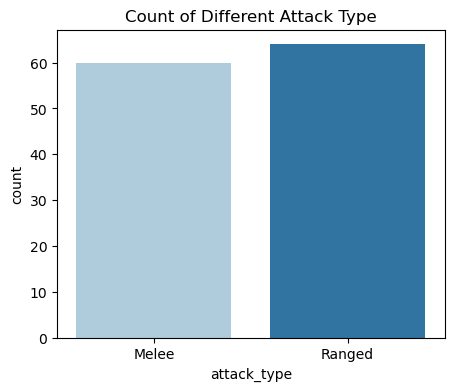

In [370]:
# account type analysis

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(5, 4))
sns.set_palette("Paired")
color_list = sns.color_palette("Paired").as_hex()
# https://seaborn.pydata.org/generated/seaborn.color_palette.html
# drawing the plot

sns.countplot(x = heroes_df['attack_type'], ax=ax)
plt.title('Count of Different Attack Type')
plt.show()
# the counts of melee and ranges are almost the same

In [684]:
color_list

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

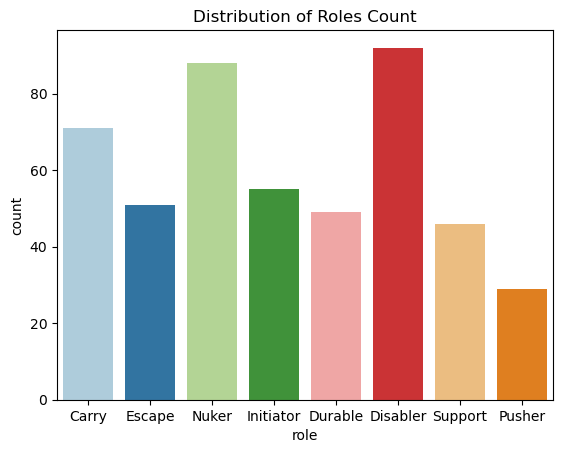

In [45]:
roles_dict = {}
for roles in heroes_df.roles.tolist():
    for role in ast.literal_eval(roles):
        # print(role)
        if role not in roles_dict:
            roles_dict[role] = 1
        else:
            roles_dict[role] += 1
sns.barplot(data = pd.DataFrame({
    'role': list(roles_dict.keys()),
    'count': list(roles_dict.values())}),
            x = 'role', y='count')
plt.title('Distribution of Roles Count')
plt.show()
# Reference: https://dota2.fandom.com/wiki/Role
# Disabler and Nuker have the highest count

### Create a graph to visualize the relationship between heroes

In [48]:
import networkx as nx
import time

In [65]:
heroes_df.head()

,hero_id,official_name,primary_attr,attack_type,roles,legs,name_id,pros,cons,bio,bad_against,good_against,work_well_with,link,attribute
0,1,Anti-Mage,agi,Melee,"['Carry', 'Escape', 'Nuker']",2,antimage,Extremely mobile and hard to catch.\nHigh atta...,Low stat gain.\nLow health and mana.\nReliant ...,"Anti-MageLink.\n▶️.\n .\n""They who live by the...","['Axe', 'Bane', 'Disruptor', 'Doom', 'Grimstro...","['Ancient Apparition', 'Abaddon', 'Arc Warden'...","['Bane', 'Bounty Hunter', 'Dazzle', 'Dark Seer...",https://dota2.fandom.com/wiki/Anti-Mage,Agility
1,2,Axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Carry']",2,axe,Powerful ganker once he gets his \nGreat at co...,May have a hard time against ranged heroes in ...,"Mogul Khan, the AxeLink.\n▶️.\n .\n""Axe is all...","['Doom', 'Jakiro', 'Necrophos', 'Night Stalker...","['Abaddon', 'Anti-Mage', 'Broodmother', 'Dazzl...","['Ancient Apparition', 'Dark Seer', 'Dazzle', ...",https://dota2.fandom.com/wiki/Axe,Strength
2,3,Bane,all,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",4,bane,Long disabling time.\nExcellent starting attri...,"No area capabilities, poor against early pushi...","Atropos, the BaneLink.\n▶️.\n .\n""I dreamt a f...","['Abaddon', 'Broodmother', 'Jakiro', 'Luna', '...","['Faceless Void', 'Legion Commander', 'Medusa'...","['Grimstroke', 'Kunkka', 'Mirana', 'Omniknight...",https://dota2.fandom.com/wiki/Bane,Universal
3,4,Bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Nuker', 'Initiator']",2,bloodseeker,Fast \nRegains health by killing enemies.\nGoo...,Lacks \nVulnerable to enemy disables.\nCounter...,"Strygwyr, the BloodseekerLink.\n▶️.\n .\n""You ...","['Abaddon', 'Dazzle', 'Ember Spirit', 'Faceles...","['Anti-Mage', 'Clinkz', 'Huskar', 'Lycan', 'Me...","['Ancient Apparition', 'Batrider', 'Bounty Hun...",https://dota2.fandom.com/wiki/Bloodseeker,Agility
4,5,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker']",2,crystalmaiden,Gives team mana regeneration.\nNumerous slows ...,Very fragile.\nHorrendous base stats (low move...,"Rylai, the Crystal MaidenLink.\n▶️.\n .\n""When...","['Bounty Hunter', 'Bristleback', 'Clockwerk', ...","['Slark', 'Phantom Assassin', 'Templar Assassi...","['Juggernaut', 'Timbersaw', 'Sven']",https://dota2.fandom.com/wiki/Crystal_Maiden,Intelligence


#### Calculate the similarity between each hero based on bios using TF-IDF.

In [361]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans
# reference: https://www.kaggle.com/code/yclaudel/recommendation-engine-with-networkx

text_content = heroes_df['bio']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                            min_df=1,      # only use words that appear at least X times
                            stop_words='english', # remove stop words
                            lowercase=True, # Convert everything to lower case 
                            use_idf=True,   # Use idf
                            norm=u'l2',     # Normalization
                            smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf_bio = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 5
# random_state has to be 2009, the id of my idol(DOTA1)
kmeans = MiniBatchKMeans(n_clusters = k, random_state=2009)
kmeans.fit(tfidf_bio)
    
request_transform = vector.transform(heroes_df['bio'])
# new column cluster based on the description
heroes_df['cluster'] = kmeans.predict(request_transform) 

heroes_df['cluster'].value_counts()

1    66
2    20
4    17
3    16
0     5
Name: cluster, dtype: int64

Check some clusters and see the heroes in each cluster

In [362]:
for cluster in range(k):
    heroes_list = heroes_df[heroes_df['cluster']==cluster].official_name.tolist()
    # print(heroes_list)
    print(f"cluster {cluster} --  heroes: {str(heroes_list)}")

cluster 0 --  heroes: ['Bane', 'Shadow Fiend', 'Puck', 'Razor', 'Sand King']
cluster 1 --  heroes: ['Axe', 'Earthshaker', 'Morphling', 'Pudge', 'Tiny', 'Windranger', 'Kunkka', 'Shadow Shaman', 'Slardar', 'Tidehunter', 'Lich', 'Enigma', 'Tinker', 'Sniper', 'Warlock', 'Wraith King', 'Templar Assassin', 'Dragon Knight', 'Dazzle', 'Leshrac', "Nature's Prophet", 'Dark Seer', 'Omniknight', 'Broodmother', 'Bounty Hunter', 'Weaver', 'Chen', 'Spectre', 'Doom', 'Ursa', 'Spirit Breaker', 'Gyrocopter', 'Alchemist', 'Invoker', 'Outworld Destroyer', 'Brewmaster', 'Lone Druid', 'Chaos Knight', 'Meepo', 'Treant Protector', 'Rubick', 'Disruptor', 'Nyx Assassin', 'Keeper of the Light', 'Io', 'Visage', 'Slark', 'Troll Warlord', 'Bristleback', 'Tusk', 'Abaddon', 'Legion Commander', 'Techies', 'Ember Spirit', 'Earth Spirit', 'Underlord', 'Phoenix', 'Arc Warden', 'Pangolier', 'Grimstroke', 'Hoodwink', 'Void Spirit', 'Snapfire', 'Dawnbreaker', 'Marci', 'Muerta']
cluster 2 --  heroes: ['Sven', 'Zeus', 'Necrop

Use the LDA topic modeling to find the keywords in each cluster. 

In [363]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=4):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    # print('**',str(return_values))
    return return_values

# def spacy_tokenizer(sentence):
#     nlp = nlp = spacy.load("en_core_web_sm")
#     return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

def LDA(best_k, X_df):
    # First, we will create k vectorizers, one for each of our cluster labels
    vectorizers = []
    
    # add stopwords
    my_additional_stop_words = {'david','voice','the','like','began','kind','boy','people'}
    stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
    for ii in range(0, best_k):
        # Creating a vectorizer
        vectorizers.append(CountVectorizer(min_df=3, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
    
    # Now we will vectorize the data from each of our clusters
    vectorized_data = []
    for current_cluster, cvec in enumerate(vectorizers):
        try:
            vectorized_data.append(cvec.fit_transform(X_df.loc[X_df['cluster'] == current_cluster, 'bio']))
        except Exception as e:
            # print("Not enough instances in cluster: " + str(current_cluster))
            vectorized_data.append(None)
            
    # number of topics per cluster
    NUM_TOPICS_PER_CLUSTER = best_k
    lda_models = []
    for ii in range(0, best_k):
        # Latent Dirichlet Allocation Model
        lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=2009)
        lda_models.append(lda)
    
    # For each cluster, we had created a corresponding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors
    clusters_lda_data = []
    for current_cluster, lda in enumerate(lda_models):
        # print("Current Cluster: " + str(current_cluster))
        
        if vectorized_data[current_cluster] != None:
            clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))
    
    # Extracts the keywords from each cluster
    all_keywords = []
    for current_vectorizer, lda in enumerate(lda_models):
        # print("Current Cluster: " + str(current_vectorizer))

        if vectorized_data[current_vectorizer] != None:
            all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
    
    return all_keywords

all_keywords = LDA(k, heroes_df)
# all_keywords

In [364]:
for cluster in range(k):
    keyword_list = all_keywords[cluster]
    # print(heroes_list)
    print(f"cluster {cluster} --  keywords: {str(keyword_list)}")

cluster 0 --  keywords: ['form', 'lore', 'responses']
cluster 1 --  keywords: ['dark', 'light', 'world', 'responses', 'seed', 'lore', 'power', 'knight', 'ancient', 'spirit', 'long']
cluster 2 --  keywords: ['beast', 'night', 'dead', 'kin', 'king', 'creature', 'responses', 'pain', 'lore', 'death', 'father', 'fate', 'high', 'son']
cluster 3 --  keywords: ['power', 'isle', 'form', 'responses', 'new', 'sacred', 'world', 'known', 'blood', 'lore', 'energy', 'life', 'creature', 'body', 'mortal', 'long', 'day']
cluster 4 --  keywords: ['demon', 'time', 'hell', 'ice', 'lore', 'responses', 'greatest', 'day', 'final', 'single', 'world', 'alias', 'waste', 'power', 'spells']


In [330]:
# Find similar : get the top_n heroes with bio similar to the target hero bio 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index] # prevent choosing itself
    return [index for index in related_docs_indices][0:top_n] 

Next, also embed the pros and cons of the heroes.

In [335]:
heroes_df.iloc[123] # unknow prs/cons for muerta, the new hero

hero_id                                                         138
official_name                                                Muerta
primary_attr                                                    int
attack_type                                                  Ranged
roles                                ['Carry', 'Nuker', 'Disabler']
legs                                                              2
name_id                                                      muerta
pros                                                            NaN
cons                                                            NaN
bio               MuertaLink.\n▶️.\n .\n"What fable of Muerta we...
bad_against       ['Abaddon', 'Nyx Assassin', 'Ancient Apparitio...
good_against      ["Nature's Prophet", 'Necrophos', 'Slark', 'Sn...
work_well_with            ['Ogre Magi', 'Dark Seer', 'Pugna', 'Io']
link                           https://dota2.fandom.com/wiki/Muerta
attribute                                       

In [336]:
tfidf_pros = vector.fit_transform(heroes_df['pros'].fillna(''))
tfidf_cons = vector.fit_transform(heroes_df['cons'].fillna(''))

In [590]:
G_rl = nx.Graph(label='HEROES_RELATIONSHIP')
start_time = time.time()

for i, rowi in heroes_df.iterrows():
    if (i%100==0):
        print(" iter {} -- {} seconds -- ".format(i, time.time()-start_time))
        
    G_rl.add_node(rowi['official_name'], key=rowi['hero_id'], label='HERO', \
        h_attr=rowi['attribute'])
    G_rl.add_edge(rowi['official_name'], rowi['official_name'], label='SAME_HERO')
    
    for element in ast.literal_eval(rowi.bad_against):
        G_rl.add_node(element, label='HERO')
        G_rl.add_edge(rowi['official_name'], element, label='BAD_AGAINST')
    
    for element in ast.literal_eval(rowi.good_against):
        G_rl.add_node(element, label='HERO')
        G_rl.add_edge(rowi['official_name'], element, label='GOOD_AGAINST')
        
    for element in ast.literal_eval(rowi.work_well_with):
        G_rl.add_node(element, label='HERO')
        G_rl.add_edge(rowi['official_name'], element, label='WORK_WELL_WITH')
        
print(" finish -- {} seconds --".format(time.time() - start_time))    

 iter 0 -- 0.0005919933319091797 seconds -- 
 iter 100 -- 0.02933788299560547 seconds -- 
 finish -- 0.03383302688598633 seconds --


In [602]:
count = 0
tmp_list = []
for (n,v) in G_rl.edges('Crystal Maiden'):
    count += 1
    if v not in tmp_list:
        tmp_list.append(v)
    else:
        print(v)
    # print(n,v,G_rl['Crystal Maiden'][v]['label'])
    
len(tmp_list)

51

In [522]:
G_sim = nx.Graph(label='HEROES_SIMILARITY')
start_time = time.time()

for i, rowi in heroes_df.iterrows():
    if (i%100==0):
        print(" iter {} -- {} seconds -- ".format(i, time.time()-start_time))

    indices_bio = find_similar(tfidf_bio, i ,top_n= 5)
    # s_bio_node = f"Sim({rowi['official_name']})Bio"
    # G_sim.add_node(s_bio_node, label='BIO_SIMILAR')
    # G_sim.add_edge(rowi['official_name'], rowi['official_name'], label='SAME_HERO')
    for element in indices_bio:
        G_sim.add_edge(rowi['official_name'], heroes_df['official_name'].loc[element], label='BIO_SIMILARITY')

    indices_pros = find_similar(tfidf_pros, i ,top_n= 5)
    # s_p_node = f"Sim({rowi['official_name']})Pro"
    # G_sim.add_node(s_p_node, label='PRO_SIMILAR')
    # G_sim.add_edge(rowi['official_name'], s_p_node, label='PRO_SIMILARITY')
    for element in indices_pros:
        G_sim.add_edge(rowi['official_name'], heroes_df['official_name'].loc[element], label='PRO_SIMILARITY')
        
    indices_cons = find_similar(tfidf_cons, i ,top_n= 5)
    # s_c_node = f"Sim({rowi['official_name']})Con"
    # G_sim.add_node(s_c_node, label='CON_SIMILAR')
    # G_sim.add_edge(rowi['official_name'], s_c_node, label='CON_SIMILARITY')
    for element in indices_cons:
        G_sim.add_edge(rowi['official_name'], heroes_df['official_name'].loc[element], label='CON_SIMILARITY') 
print(" finish -- {} seconds --".format(time.time() - start_time))   

 iter 0 -- 0.0004551410675048828 seconds -- 
 iter 100 -- 0.12111306190490723 seconds -- 
 finish -- 0.14716625213623047 seconds --


In [680]:
def get_all_adj_nodes(G, selected_hero, num_nodes):
    sub_graph = set()
    if num_nodes > 124:
        num_nodes = 124 # max hero count=124
    sub_graph.add(selected_hero)
    for e in G.neighbors(selected_hero):
        if len(sub_graph) > num_nodes:
            break
        sub_graph.add(e)
    return list(sub_graph)

def draw_sub_graph_counter(G, sub_graph, selected_hero, counter_type='BAD_AGAINST'):
    # sub_graph.remove(selected_hero)
    # sub_graph = G.subgraph(sub_graph)
    
    colors = []
    for e in sub_graph: 
        if e == selected_hero:
            print(e)
            colors.append(color_list[8]) # itself
        elif G[selected_hero][e]['label'] == 'BAD_AGAINST':
            colors.append(color_list[5])
        elif G[selected_hero][e]['label'] == 'GOOD_AGAINST':
            colors.append(color_list[1])
        elif G[selected_hero][e]['label'] == 'WORK_WELL_WITH':
            colors.append(color_list[3])
    # print(colors)
    plt.figure(figsize=(10,6))
    sub_graph = G.subgraph(sub_graph)
    print(sub_graph)
    nx.draw(sub_graph, with_labels=True, font_weight='normal', font_size=8, \
        alpha=1, node_color = colors, \
        pos=nx.spring_layout(G))
    plt.title(f'Relationship Between {selected_hero} and the Neighbors')

    hero_patch = mpatches.Patch(color=color_list[8], label='SELF')
    bad_patch = mpatches.Patch(color=color_list[5], label='BAD_AGAINST')
    good_patch = mpatches.Patch(color=color_list[1], label='GOOD_AGAINST')
    well_patch = mpatches.Patch(color=color_list[3], label='WORK_WELL_WITH')
    plt.legend(handles=[hero_patch, bad_patch, good_patch, well_patch])
    plt.show()

def draw_sub_graph_similar(G, sub_graph, selected_hero, similar_type='BIO_SIMILAR'):
    # sub_graph = G.subgraph(sub_graph)
    
    colors = []
    for e in sub_graph:
        if e == selected_hero: # itself
            colors.append(color_list[8])
        elif G[selected_hero][e]['label'] == 'BIO_SIMILARITY':
            colors.append(color_list[1])
        elif G[selected_hero][e]['label'] == 'PRO_SIMILARITY':
            colors.append(color_list[3])
        elif G[selected_hero][e]['label'] == 'CON_SIMILARITY':
            colors.append(color_list[5])
       
    # print(colors)
    sub_graph = G.subgraph(sub_graph)
    print(sub_graph)
    plt.figure(figsize=(10,6))
    nx.draw(sub_graph, with_labels=True, font_weight='normal', font_size=8, \
        alpha=1, node_color = colors, \
        pos=nx.spring_layout(G))
    plt.title(f'Similarity Between {selected_hero} and the Neighbors')

    hero_patch = mpatches.Patch(color=color_list[8], label='SELF')
    bio_patch = mpatches.Patch(color=color_list[1], label='BIO_SIMILAR')
    pro_patch = mpatches.Patch(color=color_list[3], label='PRO_SIMILAR')
    con_patch = mpatches.Patch(color=color_list[5], label='CON_SIMILAR')
    plt.legend(handles=[hero_patch, bio_patch, pro_patch, con_patch])
    plt.show()

Graph with 11 nodes and 27 edges


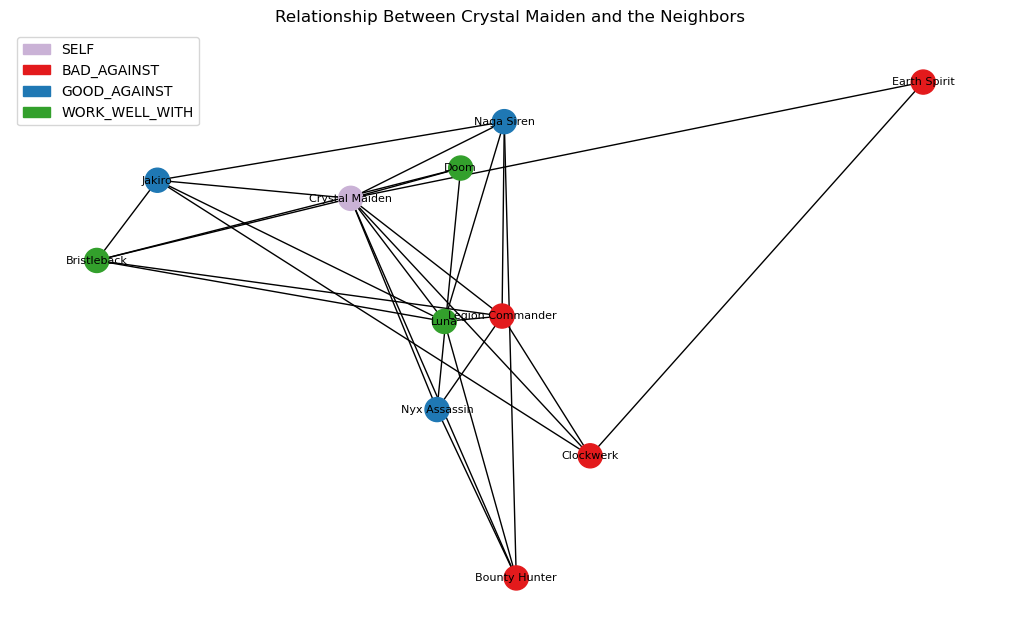

In [641]:
selected_hero = 'Crystal Maiden'
# you can choose the number of nodes to show
sub_graph = get_all_adj_nodes(G_rl, selected_hero, num_nodes = 10)

draw_sub_graph_counter(G_rl, sub_graph, selected_hero)

CM good against 'Nyx Assassin'?? Check the data:

In [603]:
# we can check the result
a = len(ast.literal_eval(heroes_df[heroes_df['official_name']==selected_hero].bad_against.tolist()[0]))
b = len(ast.literal_eval(heroes_df[heroes_df['official_name']==selected_hero].good_against.tolist()[0]))
c = len(ast.literal_eval(heroes_df[heroes_df['official_name']==selected_hero].work_well_with.tolist()[0]))
# a+b+c
heroes_df[heroes_df['official_name']==selected_hero].bad_against.tolist()

["['Bounty Hunter', 'Bristleback', 'Clockwerk', 'Doom', 'Earth Spirit', 'Jakiro', 'Legion Commander', 'Luna', 'Naga Siren', 'Nyx Assassin', 'Pudge', 'Tidehunter', 'Tusk', 'Visage']"]

In [611]:
ast.literal_eval(heroes_df[heroes_df['official_name']=='Nyx Assassin'].bad_against.tolist()[0])
ast.literal_eval(heroes_df[heroes_df['official_name']=='Nyx Assassin'].good_against.tolist()[0])

['Crystal Maiden',
 'Dawnbreaker',
 'Enchantress',
 'Enigma',
 'Ember Spirit',
 'Medusa',
 'Outworld Destroyer',
 'Phoenix',
 'Puck',
 'Pugna',
 'Silencer',
 'Sniper',
 'Storm Spirit',
 'Tinker']

Probably when we build the graph, the edges will overwrite each other. So it is recommended to build graphs one by one based on the selected heroes instead of all together! Or we can build a directed graph instead.

In [676]:
G_rl_directed = nx.DiGraph(label='HEROES_RELATIONSHIP')
start_time = time.time()

for i, rowi in heroes_df.iterrows():
    if (i%100==0):
        print(" iter {} -- {} seconds -- ".format(i, time.time()-start_time))
        
    G_rl_directed.add_node(rowi['official_name'], key=rowi['hero_id'], label='HERO', \
        h_attr=rowi['attribute'])
    # G_rl_directed.add_edges_from([(rowi['official_name'], rowi['official_name'])], label='SAME_HERO')
    
    for element in ast.literal_eval(rowi.bad_against):
        # G_rl_directed.add_node(element, label='HERO')
        G_rl_directed.add_edges_from([(rowi['official_name'], element)], label='BAD_AGAINST')
    
    for element in ast.literal_eval(rowi.good_against):
        # G_rl_directed.add_node(element, label='HERO')
        G_rl_directed.add_edges_from([(rowi['official_name'], element)], label='GOOD_AGAINST')
        
    for element in ast.literal_eval(rowi.work_well_with):
        # G_rl_directed.add_node(element, label='HERO')
        G_rl_directed.add_edges_from([(rowi['official_name'], element)], label='WORK_WELL_WITH')
        
print(" finish -- {} seconds --".format(time.time() - start_time))    

 iter 0 -- 0.00044918060302734375 seconds -- 
 iter 100 -- 0.025166034698486328 seconds -- 
 finish -- 0.030372142791748047 seconds --


In [717]:
print(sub_graph)

['Luna', 'Jakiro', 'Naga Siren', 'Tidehunter', 'Doom', 'Bristleback', 'Visage', 'Legion Commander', 'Clockwerk', 'Bounty Hunter', 'Nyx Assassin', 'Earth Spirit', 'Pudge', 'Slark', 'Tusk', 'Crystal Maiden']


In [719]:
colors

['#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#1f78b4',
 '#e31a1c',
 '#cab2d6']

In [727]:
selected_hero = 'Crystal Maiden'
# you can choose the number of nodes to show
sub_graph = get_all_adj_nodes(G_rl_directed, selected_hero, num_nodes = 15)
# sub_graph
colors = []
color_map = []
for e in sub_graph: 
    if e == selected_hero:
        colors.append(color_list[8]) # itself
        color_map.append((e,e,color_list[8]))
    elif G_rl_directed[selected_hero][e]['label'] == 'BAD_AGAINST':
        colors.append(color_list[5])
        color_map.append((selected_hero,e,color_list[5]))
    elif G_rl_directed[selected_hero][e]['label'] == 'GOOD_AGAINST':
        colors.append(color_list[1])
        color_map.append((selected_hero,e,color_list[1]))
    elif G_rl_directed[selected_hero][e]['label'] == 'WORK_WELL_WITH':
        colors.append(color_list[3])
        color_map.append((selected_hero,e,color_list[3]))

# print(color_map)
plt.figure(figsize=(10,6))

sub_G = nx.DiGraph()
for edge in color_map:
    sub_G.add_edges_from([(edge[0], edge[2], {"color": edge[-1]})])
# print(sub_graph)
color_map

sub_G.add_edges_from([(edge[0], edge[2], {"color": edge[-1]})])
# nx.draw(sub_graph, with_labels=True, font_weight='normal', font_size=8, \
#     alpha=1, node_color = [x[-1] for x in color_map], \
#     pos=nx.spring_layout(G_rl_directed))
# plt.title(f'Relationship Between {selected_hero} and the Neighbors')

# hero_patch = mpatches.Patch(color=color_list[8], label='SELF')
# bad_patch = mpatches.Patch(color=color_list[5], label='BAD_AGAINST')
# good_patch = mpatches.Patch(color=color_list[1], label='GOOD_AGAINST')
# well_patch = mpatches.Patch(color=color_list[3], label='WORK_WELL_WITH')
# plt.legend(handles=[hero_patch, bad_patch, good_patch, well_patch])
# plt.show()

[('Crystal Maiden', 'Luna', '#e31a1c'),
 ('Crystal Maiden', 'Jakiro', '#e31a1c'),
 ('Crystal Maiden', 'Naga Siren', '#e31a1c'),
 ('Crystal Maiden', 'Tidehunter', '#e31a1c'),
 ('Crystal Maiden', 'Doom', '#e31a1c'),
 ('Crystal Maiden', 'Bristleback', '#e31a1c'),
 ('Crystal Maiden', 'Visage', '#e31a1c'),
 ('Crystal Maiden', 'Legion Commander', '#e31a1c'),
 ('Crystal Maiden', 'Clockwerk', '#e31a1c'),
 ('Crystal Maiden', 'Bounty Hunter', '#e31a1c'),
 ('Crystal Maiden', 'Nyx Assassin', '#e31a1c'),
 ('Crystal Maiden', 'Earth Spirit', '#e31a1c'),
 ('Crystal Maiden', 'Pudge', '#e31a1c'),
 ('Crystal Maiden', 'Slark', '#1f78b4'),
 ('Crystal Maiden', 'Tusk', '#e31a1c'),
 ('Crystal Maiden', 'Crystal Maiden', '#cab2d6')]

<Figure size 1000x600 with 0 Axes>

In [672]:
G_rl_directed.subgraph(sub_graph).edges()

OutEdgeView([('Luna', 'Bristleback'), ('Luna', 'Juggernaut'), ('Luna', 'Pudge'), ('Luna', 'Slark'), ('Luna', 'Bounty Hunter'), ('Luna', 'Crystal Maiden'), ('Luna', 'Legion Commander'), ('Luna', 'Phantom Assassin'), ('Luna', 'Terrorblade'), ('Luna', 'Tidehunter'), ('Luna', 'Visage'), ('Luna', 'Jakiro'), ('Luna', 'Naga Siren'), ('Luna', 'Sven'), ('Tidehunter', 'Nyx Assassin'), ('Tidehunter', 'Luna'), ('Tidehunter', 'Juggernaut'), ('Tidehunter', 'Slark'), ('Tidehunter', 'Jakiro'), ('Timbersaw', 'Doom'), ('Timbersaw', 'Phantom Assassin'), ('Timbersaw', 'Slark'), ('Timbersaw', 'Terrorblade'), ('Timbersaw', 'Bounty Hunter'), ('Timbersaw', 'Crystal Maiden'), ('Terrorblade', 'Crystal Maiden'), ('Terrorblade', 'Earth Spirit'), ('Terrorblade', 'Jakiro'), ('Terrorblade', 'Luna'), ('Terrorblade', 'Timbersaw'), ('Terrorblade', 'Sven'), ('Terrorblade', 'Nyx Assassin'), ('Terrorblade', 'Pudge'), ('Crystal Maiden', 'Bounty Hunter'), ('Crystal Maiden', 'Bristleback'), ('Crystal Maiden', 'Clockwerk'), (

In [659]:
ast.literal_eval(heroes_df[heroes_df['official_name']==selected_hero].good_against.tolist()[0])

['Slark', 'Phantom Assassin', 'Templar Assassin', 'Terrorblade']

['Jakiro', 'Skywrath Mage', 'Bane', 'Lina', 'Anti-Mage', 'Meepo', 'Rubick', 'Crystal Maiden', 'Ancient Apparition']


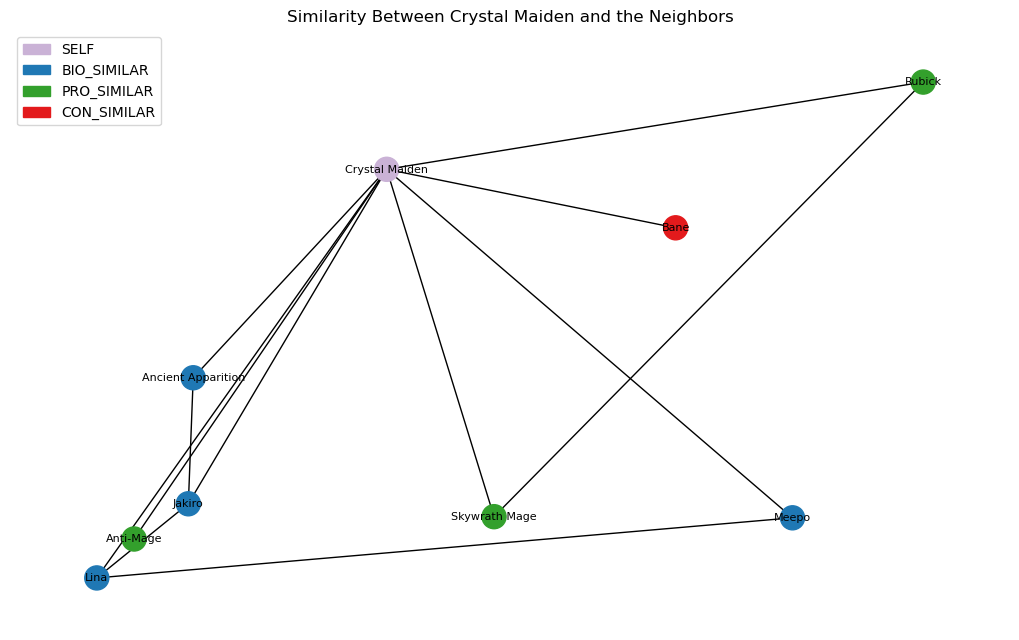

In [612]:
selected_hero = 'Crystal Maiden'
# you can choose the number of nodes to show
sub_graph = get_all_adj_nodes(G_sim, selected_hero,num_nodes = 8)
draw_sub_graph_similar(G_sim, sub_graph, selected_hero)

In [620]:
# we can check the result
heroes_df[heroes_df['official_name']==selected_hero].cons.to_list()[0].split('\n')

['Very fragile.',
 'Horrendous base stats (low movement speed, low damage, low attributes).',
 'Ultimate requires channeling and requires her to be in close range with her enemies.']

In [619]:
heroes_df[heroes_df['official_name']=='Bane'].cons.to_list()[0].split('\n')

['No area capabilities, poor against early pushing line ups and illusion heroes.',
 'Low mobility.',
 "Fiend's Grip requires channeling.",
 'Low attack range.',
 'Mediocre intelligence gain for a hero with low-cooldown high-mana-cost spells.']

Based on the speed and the attack range, yes CM and bane seem to have similar cons.

### Explore the matches

In [254]:
player_df = pd.read_csv('player.csv')
team_df = pd.read_csv('team.csv')

In [255]:
player_df = player_df.merge(team_df, on='match_id')
player_df.head()

,match_id,camp,hero_id,hero_name,player,player_id,lane_role,6_min_last_hits,purchase_ward_count,gold_per_min,hero_damage,tower_damage,rank_tier,region,isRadiant,win,lose,total_gold,total_xp,kills_per_min,kda,abandons,neutral_kills,tower_kills,courier_kills,lane_kills,hero_kills,observer_kills,sentry_kills,roshan_kills,necronomicon_kills,ancient_kills,buyback_count,observer_uses,sentry_uses,start_time,duration,win_camp,radiant_hero,dire_hero,radiant_score,dire_score,game_mode
0,7146139538,radiant,43,Death Prophet,NaN,1459205302,mid,26.0,5,455,18688.0,1262.0,NaN,3.0,True,0,1,10684,11459,0.212917,1,0,17.0,1.0,0.0,111.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
1,7146139538,radiant,64,Jakiro,NaN,1459031599,safe,0.0,15,221,6709.0,435.0,NaN,3.0,True,0,1,5189,7632,NaN,0,0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
2,7146139538,radiant,108,Underlord,NaN,1423366323,off,36.0,1,366,5446.0,465.0,NaN,3.0,True,0,1,8594,7444,NaN,0,0,8.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
3,7146139538,radiant,72,Gyrocopter,NaN,1458610209,off,0.0,6,298,12596.0,382.0,NaN,3.0,True,0,1,6998,6246,0.255500,0,0,8.0,0.0,0.0,21.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
4,7146139538,radiant,89,Naga Siren,NaN,1459124273,safe,29.0,0,455,6441.0,52.0,NaN,3.0,True,0,1,10684,10896,0.085167,0,0,126.0,0.0,0.0,69.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2


In [262]:
# you can filter the data as you wish, but you'd better get as many teams as possible
# filtered_team_df = team_df[(team_df['start_time'] >= '23-01-01') & (team_df['start_time'] < '23-05-09')]
filtered_team_df = team_df
len(filtered_team_df)

49080

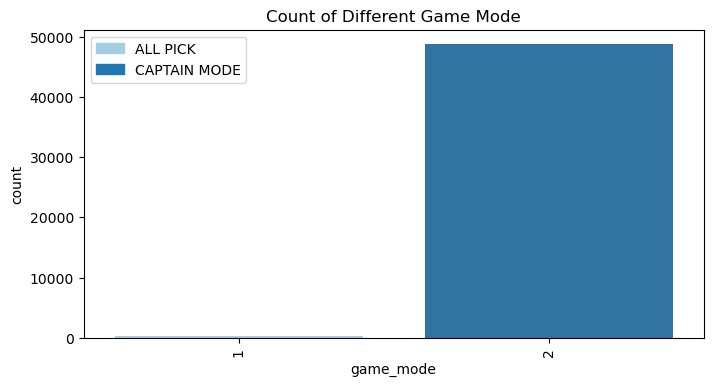

In [272]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x = filtered_team_df['game_mode'], ax=ax)
plt.xticks(rotation=90, fontsize=10)
plt.title('Count of Different Game Mode')
mode1_patch = mpatches.Patch(color='#a6cee3', label='ALL PICK')
mode2_patch = mpatches.Patch(color='#1f78b4', label='CAPTAIN MODE')
plt.legend(handles=[mode1_patch, mode2_patch])
plt.show()

The data are mainly from captain mode, which is likely to be public match data.

In [256]:
# filter the time if you want
# here I filter the date after the new version
filtered_player_df = player_df.loc[(player_df['start_time'] >= '23-04-21') & (player_df['start_time'] < '23-05-09')]
filtered_player_df.head()

,match_id,camp,hero_id,hero_name,player,player_id,lane_role,6_min_last_hits,purchase_ward_count,gold_per_min,hero_damage,tower_damage,rank_tier,region,isRadiant,win,lose,total_gold,total_xp,kills_per_min,kda,abandons,neutral_kills,tower_kills,courier_kills,lane_kills,hero_kills,observer_kills,sentry_kills,roshan_kills,necronomicon_kills,ancient_kills,buyback_count,observer_uses,sentry_uses,start_time,duration,win_camp,radiant_hero,dire_hero,radiant_score,dire_score,game_mode
0,7146139538,radiant,43,Death Prophet,NaN,1459205302,mid,26.0,5,455,18688.0,1262.0,NaN,3.0,True,0,1,10684,11459,0.212917,1,0,17.0,1.0,0.0,111.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
1,7146139538,radiant,64,Jakiro,NaN,1459031599,safe,0.0,15,221,6709.0,435.0,NaN,3.0,True,0,1,5189,7632,NaN,0,0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
2,7146139538,radiant,108,Underlord,NaN,1423366323,off,36.0,1,366,5446.0,465.0,NaN,3.0,True,0,1,8594,7444,NaN,0,0,8.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
3,7146139538,radiant,72,Gyrocopter,NaN,1458610209,off,0.0,6,298,12596.0,382.0,NaN,3.0,True,0,1,6998,6246,0.255500,0,0,8.0,0.0,0.0,21.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2
4,7146139538,radiant,89,Naga Siren,NaN,1459124273,safe,29.0,0,455,6441.0,52.0,NaN,3.0,True,0,1,10684,10896,0.085167,0,0,126.0,0.0,0.0,69.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,2


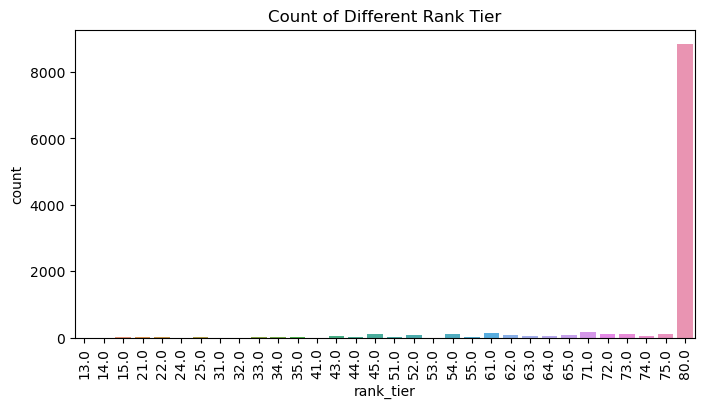

In [257]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x = filtered_player_df['rank_tier'], ax=ax)
plt.xticks(rotation=90, fontsize=10)
plt.title('Count of Different Rank Tier')
plt.show()

It seems that the matches are collected with players in high rank. So the analysis is reliable as it based on more professional data.

In [258]:
# select the first 10000 hero and win rate
hero_win_rate_df = filtered_player_df.groupby(['hero_id'])['win'].mean().reset_index()
hero_win_rate_df = hero_win_rate_df.sort_values(by='win', ascending=False)
hero_win_rate_df.head()

,hero_id,win
80,82,0.653846
51,53,0.631579
111,113,0.625000
78,80,0.620690
61,63,0.596774


In [259]:
hero_id_to_name = dict(zip(heroes_df['hero_id'].values, heroes_df['official_name'].values))
hero_win_rate_df['hero_name'] = hero_win_rate_df['hero_id'].apply(lambda x:hero_id_to_name[x])
hero_win_rate_df

,hero_id,win,hero_name
80,82,0.653846,Meepo
51,53,0.631579,Nature's Prophet
111,113,0.625000,Arc Warden
78,80,0.620690,Lone Druid
61,63,0.596774,Weaver
...,...,...,...
27,29,0.342857,Tidehunter
48,50,0.322581,Dazzle
7,8,0.312500,Juggernaut
72,74,0.311475,Invoker


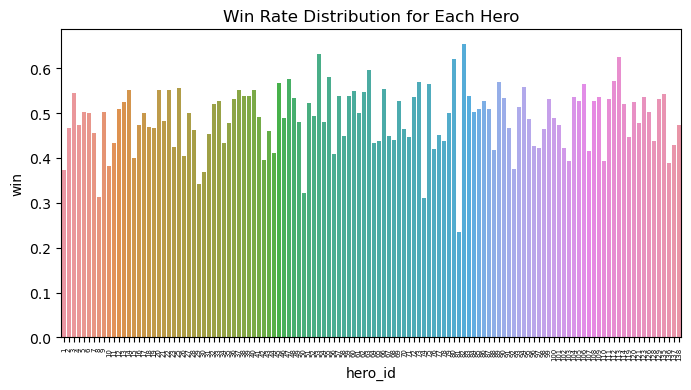

In [260]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=hero_win_rate_df, x="hero_id", y="win", ax=ax)
plt.xticks(fontsize=5, rotation = 90)
plt.title('Win Rate Distribution for Each Hero')
plt.show()

In [169]:
# win_index = hero_win_rate_df.index.tolist() # sorted by global win rate
hero_df_by_camp = filtered_player_df.groupby(['hero_id', 'camp'])['win'].mean().reset_index()
# hero_df_by_camp = hero_df_by_camp.loc[win_index]
hero_df_by_camp

,hero_id,camp,win
0,1,dire,0.304348
1,1,radiant,0.426230
2,2,dire,0.555556
3,2,radiant,0.406250
4,3,dire,0.538462
...,...,...,...
243,136,radiant,0.411765
244,137,dire,0.434783
245,137,radiant,0.416667
246,138,dire,0.448819


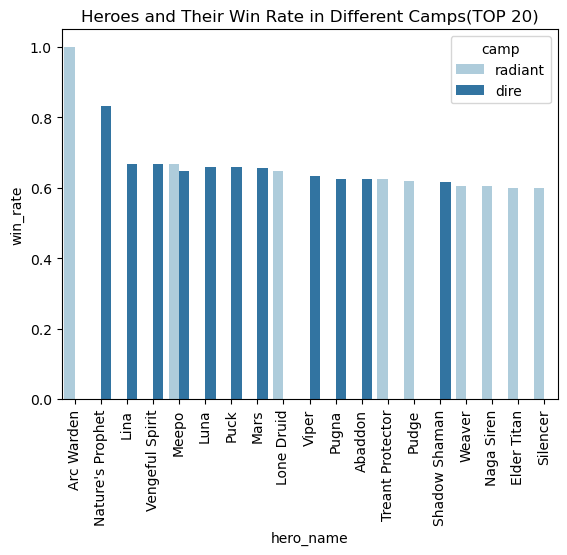

In [261]:
hero_df_by_camp['hero_name'] = hero_df_by_camp['hero_id'].apply(lambda x:hero_id_to_name[x])
hero_df_by_camp = hero_df_by_camp.sort_values(by='win', ascending=False)
sns.barplot(data=hero_df_by_camp.head(20), x="hero_name", y="win", hue='camp')
plt.xticks(fontsize=10, rotation = 90)
plt.ylabel('win_rate')
plt.title('Heroes and Their Win Rate in Different Camps(TOP 20)')
plt.show()

In [199]:
def get_hero_pair_win(team_df):
    hero_pairs = []
    for _, row in team_df.iterrows():
    # for r_heroes in team_df.iterrows():
        r_heroes = row['radiant_hero']
        r_heroes = list(ast.literal_eval(r_heroes).keys())
        r_hero_pairs = list(combinations(r_heroes,2))
        for pair in r_hero_pairs:
            hero_pair = {}
            if row['win_camp'] == 'radiant':
                hero_pair[pair] = 1
            else:
                hero_pair[pair] = 0
            hero_pairs.append(hero_pair)

        d_heroes = row['dire_hero']
        d_heroes = list(ast.literal_eval(d_heroes).keys())
        d_hero_pairs = list(combinations(d_heroes,2))
        for pair in d_hero_pairs:
            hero_pair = {}
            if row['win_camp'] == 'radiant':
                hero_pair[pair] = 0
            else:
                hero_pair[pair] = 1
            hero_pairs.append(hero_pair)

    hero1, hero2, is_win = [], [], []
    for item in hero_pairs:
        # print(item)
        hero_pair = list(item.keys())[0]
        win = list(item.values())[0]
        hero1.append(hero_name_to_id[hero_pair[0]])
        hero2.append(hero_name_to_id[hero_pair[1]])
        is_win.append(win)
    hero_win_df = pd.DataFrame({
    'hero1': hero1,
    'hero2': hero2,
    'is_win': is_win
    })
    return hero_win_df
hero_name_to_id = dict(zip(heroes_df['official_name'].values, heroes_df['hero_id'].values))

In [205]:
hero_pair_win_df = get_hero_pair_win(filtered_team_df)
hero_pair_win_df_grouped = hero_pair_win_df.groupby(['hero1', 'hero2']).mean().reset_index()
hero_pair_win_pivot = hero_pair_win_df_grouped.pivot(index='hero1', columns='hero2', values='is_win')

In [206]:
hero_pair_win_pivot

hero2,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,119,120,121,123,126,128,129,135,136,137,138
hero1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.366667,0.493333,0.214286,0.596774,0.000000,0.407407,0.500000,0.519608,1.000000,0.666667,0.250000,0.486842,0.564103,0.541667,0.555556,0.491803,0.666667,0.422680,0.538462,0.617021,0.545455,0.571429,0.460000,0.464286,0.441860,0.133333,0.506667,0.520000,0.557692,0.388889,0.562500,0.615385,0.428571,0.692308,0.562500,0.568182,0.448718,0.388889,0.200000,0.200000,0.506667,1.000000,0.619048,0.440000,0.632653,1.000000,0.471910,0.409091,0.448276,0.575758,0.450000,0.400000,0.545455,0.000000,0.470588,0.512500,0.428571,0.473684,0.625000,0.333333,0.558140,0.455556,0.406250,0.500000,NaN,0.500000,0.473684,0.666667,0.487805,0.500000,0.636364,0.568966,0.488889,0.480000,0.523810,0.500000,0.566038,0.500000,0.379310,0.333333,0.676471,0.447761,0.566265,0.440789,0.487805,0.459459,1.000000,0.456522,0.581818,0.555556,NaN,1.000000,0.666667,0.500000,0.468085,0.340000,0.000000,0.493827,0.520548,0.476190,0.384615,0.540541,0.379310,0.489796,0.441860,0.437500,0.000000,0.433333,0.500000,0.375000,0.000000,0.550000,0.483871,0.500000,0.455285,0.592593,0.434211,0.481928,0.588957,0.468085,0.666667,0.605263,1.000000
2,0.538462,NaN,0.580000,0.227273,0.451613,0.366667,0.444444,0.473684,0.481752,0.424242,0.447761,0.666667,0.448276,0.531250,0.593750,0.562500,0.529412,0.500000,0.422222,0.423077,0.666667,0.500000,0.388889,0.436893,0.354545,0.333333,0.666667,0.500000,0.400000,0.571429,0.421053,0.800000,0.400000,0.516129,0.666667,0.440000,0.571429,0.436364,0.333333,0.384615,0.477273,0.565217,0.288462,0.625000,0.600000,0.548387,0.579710,0.461538,0.500000,0.555556,0.442623,0.434783,0.448980,0.583333,0.333333,0.500000,0.513158,0.312500,0.500000,0.625000,0.400000,0.303030,0.432836,0.434783,1.000000,0.344828,0.407895,0.409091,0.478261,0.285714,0.477273,0.562500,0.364865,0.514286,0.393939,0.625000,0.500000,0.489362,0.545455,0.500000,0.500000,0.471698,0.355263,0.434783,0.503401,0.513514,0.541667,0.565217,0.425532,0.500000,0.500000,0.475000,0.500000,0.400000,0.250000,0.588235,0.411765,0.388889,0.482759,0.500000,0.421053,0.476190,0.500000,0.481481,0.423077,0.461538,0.250000,0.500000,0.370370,0.517241,0.367647,0.454545,0.465116,0.607143,0.571429,0.428571,0.443478,0.387755,0.526316,0.428571,0.588235,0.548387,0.571429,0.333333
3,0.526316,0.569231,NaN,0.574468,0.250000,0.508197,0.553191,0.590361,0.651568,0.468254,0.569444,0.552632,0.544643,0.500000,0.535948,0.549296,0.596939,0.535714,0.532423,0.675000,0.602941,0.510204,0.573529,0.574257,0.507692,0.660000,0.583333,0.600985,0.250000,1.000000,0.695652,0.488372,0.515152,0.305556,0.546667,0.000000,0.631285,0.534091,0.740000,0.516484,0.558282,0.537634,0.477419,0.571429,0.561947,0.487500,0.577778,0.577640,0.600000,0.486486,0.575758,0.563636,0.496241,0.644444,0.562500,0.600000,0.549020,0.555556,0.529762,0.638298,0.600000,0.503145,0.487179,0.465909,0.555556,0.511628,0.750000,0.474747,0.509615,0.544554,0.553846,0.600000,0.553571,0.432432,0.606061,0.597015,0.521739,0.581818,0.565217,0.600000,0.666667,0.666667,0.529412,0.535714,0.463415,0.500000,0.622449,0.450000,0.537815,0.726619,0.544118,0.508197,0.590909,0.500000,0.525641,0.495050,0.560606,0.500000,0.553398,0.570755,0.600000,0.750000,0.468750,0.545455,0.567376,0.581818,0.387755,0.648855,0.650794,0.333333,0.604651,1.000000,0.635246,0.606061,0.520362,0.447761,0.500000,0.537688,0.538168,0.573770,0.666667,0.538462,0.500000,0.000000
4,0.500000,0.652174,0.445205,NaN,0.459259,0.166667,0.514286,0.294118,0.485714,0.588235,0.444444,0.666667,0.579365,0.382979,0.486111,0.487179,0.572

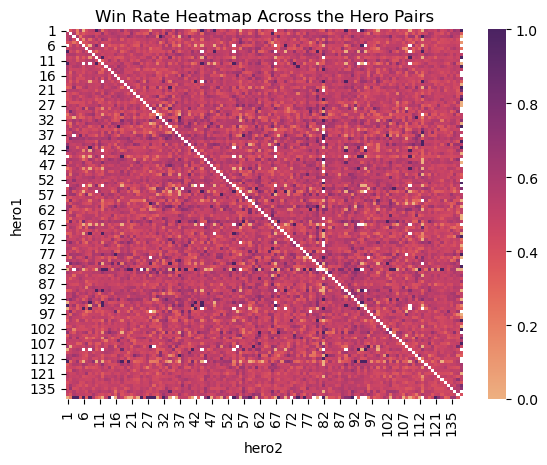

In [207]:
sns.heatmap(hero_pair_win_pivot, cmap="flare")
plt.title('Win Rate Heatmap Across the Hero Pairs')
plt.show()

In [220]:
hero_pair_win_pivot[1][8]

1.0

In [222]:
hero_id_to_name[1], hero_id_to_name[8]

('Anti-Mage', 'Juggernaut')

As we can see, pair (82, 138) has the winning rate 1, which means that AM and JUGG together will have 100% win rate. It is counter-intuitive because they are two carrys and not likely to be chosen together. However, when crazy people choose them, they may win.

In [247]:
# Find the columns that aren't in the first DataFrame
different_cols = set(team_df.columns.intersection(player_df.columns))
different_cols.remove('match_id')
# different_cols

# Filter out the columns that are different.
# You could pass in the df2[diff_cols]
# directly into the merge as well.
player_df.drop(different_cols, axis=1, inplace=True)
 
# # Merge the DataFrames
merged_df = team_df.merge(player_df, on='match_id', how='left')

Next merge the heros, the players and the matches together.

In [250]:
merged_df = merged_df.merge(heroes_df, on='hero_id', how='left')
merged_df.to_csv('merged_data.csv', index=False, header=True)
merged_df.head()

,match_id,start_time,duration,win_camp,radiant_hero,dire_hero,radiant_score,dire_score,camp,hero_id,hero_name,player,player_id,lane_role,6_min_last_hits,purchase_ward_count,gold_per_min,hero_damage,tower_damage,rank_tier,region,isRadiant,win,lose,total_gold,total_xp,kills_per_min,kda,abandons,neutral_kills,tower_kills,courier_kills,lane_kills,hero_kills,observer_kills,sentry_kills,roshan_kills,necronomicon_kills,ancient_kills,buyback_count,observer_uses,sentry_uses,official_name,primary_attr,attack_type,roles,legs,name_id,pros,cons,bio,bad_against,good_against,work_well_with,link,attribute
0,7146139538,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,radiant,43,Death Prophet,NaN,1459205302,mid,26.0,5,455,18688.0,1262.0,NaN,3.0,True,0,1,10684,11459,0.212917,1,0,17.0,1.0,0.0,111.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,Death Prophet,int,Ranged,"['Carry', 'Pusher', 'Nuker', 'Disabler']",2,deathprophet,Can push lanes and destroy towers quickly.\nHi...,Lack of escape ability.\nLong cast animation b...,"Krobelus, the Death ProphetLink.\n▶️.\n .\n""Wh...","['Ancient Apparition', 'Anti-Mage', 'Doom', 'L...","['Bounty Hunter', 'Clockwerk', 'Chen', 'Invoke...","['Enigma', 'Faceless Void', 'Keeper of the Lig...",https://dota2.fandom.com/wiki/Death_Prophet,Intelligence
1,7146139538,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,radiant,64,Jakiro,NaN,1459031599,safe,0.0,15,221,6709.0,435.0,NaN,3.0,True,0,1,5189,7632,NaN,0,0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Jakiro,int,Ranged,"['Support', 'Nuker', 'Pusher', 'Disabler']",2,jakiro,"Tanky lane support, great harasser.\nEffective...",Predictable abilities due to longer cast point...,"Jakiro, the Twin Head DragonLink.\n▶️.\n .\n""T...","['Anti-Mage', 'Clockwerk', 'Lifestealer', 'Ora...","['Axe', 'Bane', 'Batrider', 'Bristleback', 'Br...","['Dark Seer', 'Enchantress', 'Faceless Void', ...",https://dota2.fandom.com/wiki/Jakiro,Intelligence
2,7146139538,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,radiant,108,Underlord,NaN,1423366323,off,36.0,1,366,5446.0,465.0,NaN,3.0,True,0,1,8594,7444,NaN,0,0,8.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Underlord,str,Melee,"['Support', 'Nuker', 'Disabler', 'Durable', 'E...",2,underlord,Excellent zoning abilities.\nTankier than most...,Low mana.\nRequires good team coordination.\nS...,"Vrogros, the UnderlordLink.\n▶️.\n .\n""Nothing...","['Necrophos', 'Razor', 'Luna', 'Disruptor', 'K...","['Drow Ranger', 'Legion Commander', 'Phantom L...","['Disruptor', 'Dragon Knight', 'Elder Titan', ...",https://dota2.fandom.com/wiki/Underlord,Strength
3,7146139538,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,radiant,72,Gyrocopter,NaN,1458610209,off,0.0,6,298,12596.0,382.0,NaN,3.0,True,0,1,6998,6246,0.255500,0,0,8.0,0.0,0.0,21.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,Gyrocopter,agi,Ranged,"['Carry', 'Nuker', 'Disabler']",2,gyrocopter,Deals wide area damage.\nHigh early game damag...,Relatively fragile.\nShorter attack range than...,"Aurel, the GyrocopterLink.\n▶️.\n .\n""So much ...","['Anti-Mage', 'Arc Warden', 'Huskar', 'Faceles...","['Meepo', 'Undying', 'Phantom Lancer', 'Chaos ...","['Bloodseeker', 'Disruptor', 'Earthshaker', 'E...",https://dota2.fandom.com/wiki/Gyrocopter,Agility
4,7146139538,23-05-08,1409,dire,"{'Death Prophet': ['core', 1459205302], 'Jakir...","{'Queen of Pain': ['hard_support', 1526386891]...",14,34,radiant,89,Naga Siren,NaN,1459124273,safe,29.0,0,455,6441.0,52.0,NaN,3.0,True,0,1,10684,10896,0.085167,0,0,126.0,0.0,0.0,69.0,2.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,Naga Siren,agi,Melee,"['Carry', 'Support', 'Pusher', 'Disabler', 'In...",0,nagasiren,Role versatility.\nGood at split pushing and w...,Farm dependent n

In [ ]:
# to do: try to build the graph for GN/ try to build the prediction model with features
# ideally, 10 heroes with some attributes like lanerole, rank tier, attack_type, primary_attribute
# Later we can even use an LDA topic model  to detect the keywords in each cluster.

In [ ]:
# recover the code
# develop an end-to-end prediction system
# set a sample to predict winning camp